In [26]:
import pandas as pd
import numpy as np
from torch_geometric.data import Data
import torch
from torch import Tensor 
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import torch
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Data Load and Processing

In [3]:
path = "./data/"
cites = path + "cora.cites"
content = path + "cora.content"

# 索引字典，将原本的论文id转换到从0开始编码
index_dict = dict()
# 标签字典，将字符串标签转化为数值
label_to_index = dict()

features = []
labels = []
edge_index = []

with open(content,"r") as f:
    nodes = f.readlines()
    for node in nodes:
        node_info = node.split()
        index_dict[int(node_info[0])] = len(index_dict)
        features.append([int(i) for i in node_info[1:-1]])
        
        label_str = node_info[-1]
        if(label_str not in label_to_index.keys()):
            label_to_index[label_str] = len(label_to_index)
        labels.append(label_to_index[label_str])

with open(cites,"r") as f:
    edges = f.readlines()
    for edge in edges:
        start, end = edge.split()
        # 训练时将边视为无向的，但原本的边是有向的，因此需要正反添加两次
        edge_index.append([index_dict[int(start)],index_dict[int(end)]])
        edge_index.append([index_dict[int(end)],index_dict[int(start)]])
  
# 转换为Tensor
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# 行归一化
# features = torch.nn.functional.normalize(features, p=1, dim=1)
edge_index =  torch.LongTensor(edge_index)

### Initial Visulization

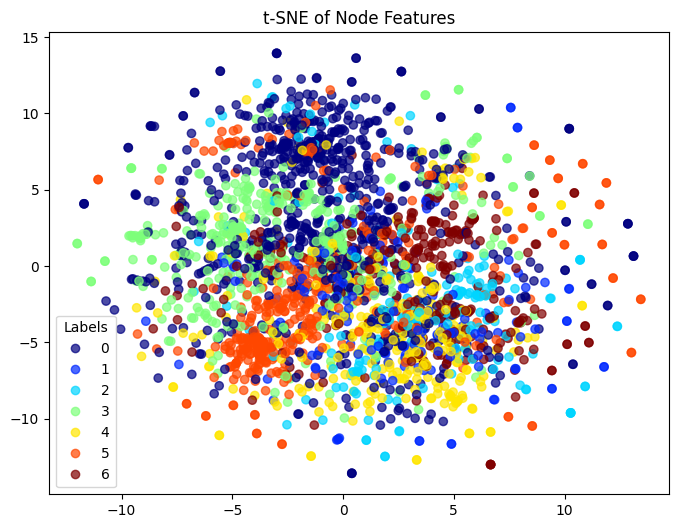

In [21]:
# 节点特征的t-SNE降维可视化
def visualize_features_tsne(features, labels):
    tsne = TSNE(n_components=2)
    reduced_features = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='jet', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Labels")
    plt.title('t-SNE of Node Features')
    plt.show()

visualize_features_tsne(features.numpy(), labels.numpy())

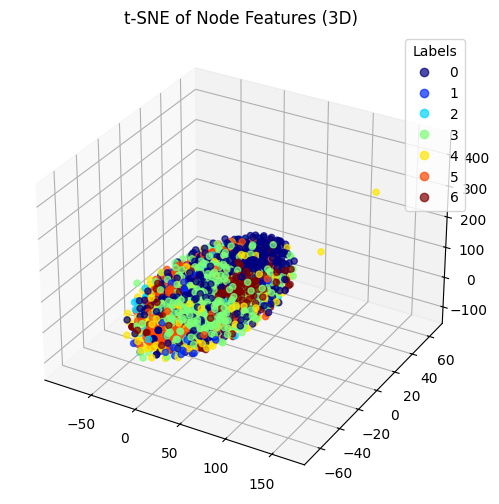

In [22]:
from mpl_toolkits.mplot3d import Axes3D
# 节点特征的t-SNE降维可视化（三维）
def visualize_features_tsne_3d(features, labels):
    tsne = TSNE(n_components=3)
    reduced_features = tsne.fit_transform(features)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=labels, cmap='jet', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Labels")
    plt.title('t-SNE of Node Features (3D)')
    plt.show()

visualize_features_tsne_3d(features.numpy(), labels.numpy())

## Baseline Model

### Logistic Regression

In [19]:
# 定义 Logistic Regression 模型
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

# 初始化模型、损失函数和优化器
input_dim = features.shape[1]
output_dim = len(label_to_index)
model = LogisticRegression(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 划分训练集和测试集
train_indices, test_indices = train_test_split(range(len(labels)), test_size=0.2, random_state=42)
train_features = features[train_indices]
train_labels = labels[train_indices]
test_features = features[test_indices]
test_labels = labels[test_indices]

# 训练模型
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 评估模型
model.eval()
with torch.no_grad():
    test_outputs = model(test_features)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(test_labels.cpu(), predicted.cpu())
    print(f'Accuracy on test set: {accuracy:.4f}')

Epoch [10/200], Loss: 1.1510
Epoch [20/200], Loss: 0.7016
Epoch [30/200], Loss: 0.4836
Epoch [40/200], Loss: 0.3609
Epoch [50/200], Loss: 0.2853
Epoch [60/200], Loss: 0.2352
Epoch [70/200], Loss: 0.1996
Epoch [80/200], Loss: 0.1730
Epoch [90/200], Loss: 0.1524
Epoch [100/200], Loss: 0.1358
Epoch [110/200], Loss: 0.1222
Epoch [120/200], Loss: 0.1108
Epoch [130/200], Loss: 0.1012
Epoch [140/200], Loss: 0.0929
Epoch [150/200], Loss: 0.0857
Epoch [160/200], Loss: 0.0794
Epoch [170/200], Loss: 0.0739
Epoch [180/200], Loss: 0.0690
Epoch [190/200], Loss: 0.0646
Epoch [200/200], Loss: 0.0607
Accuracy on test set: 0.7214


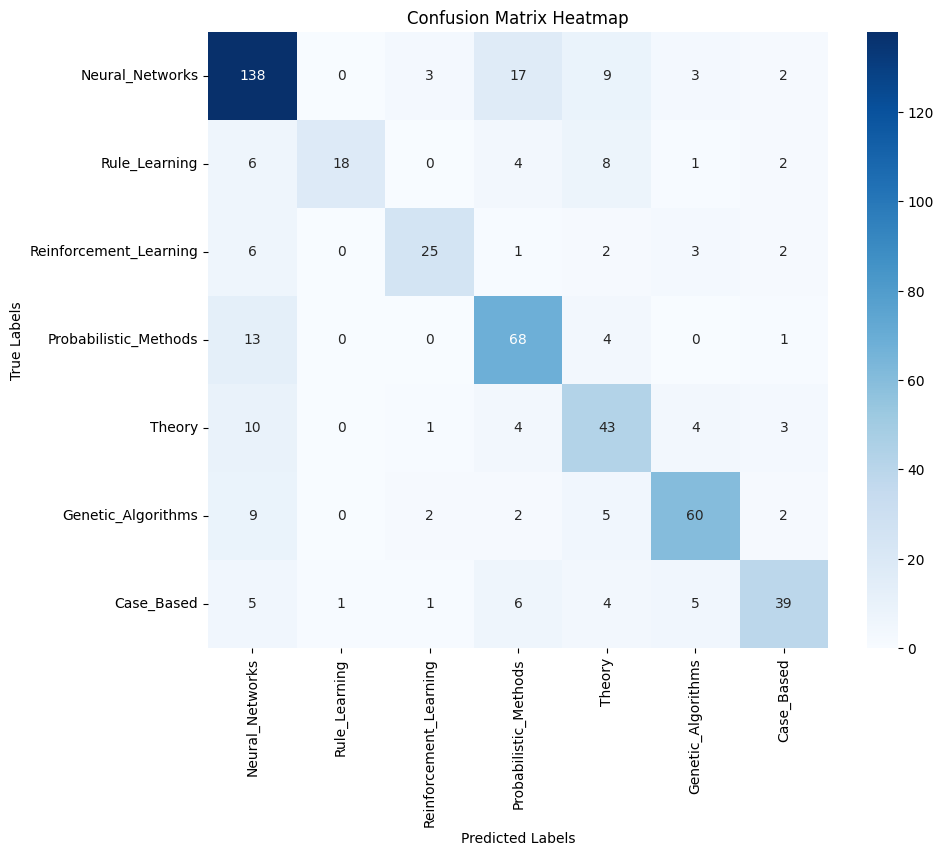

In [20]:
cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Random Forest

Accuracy on test set: 0.7583


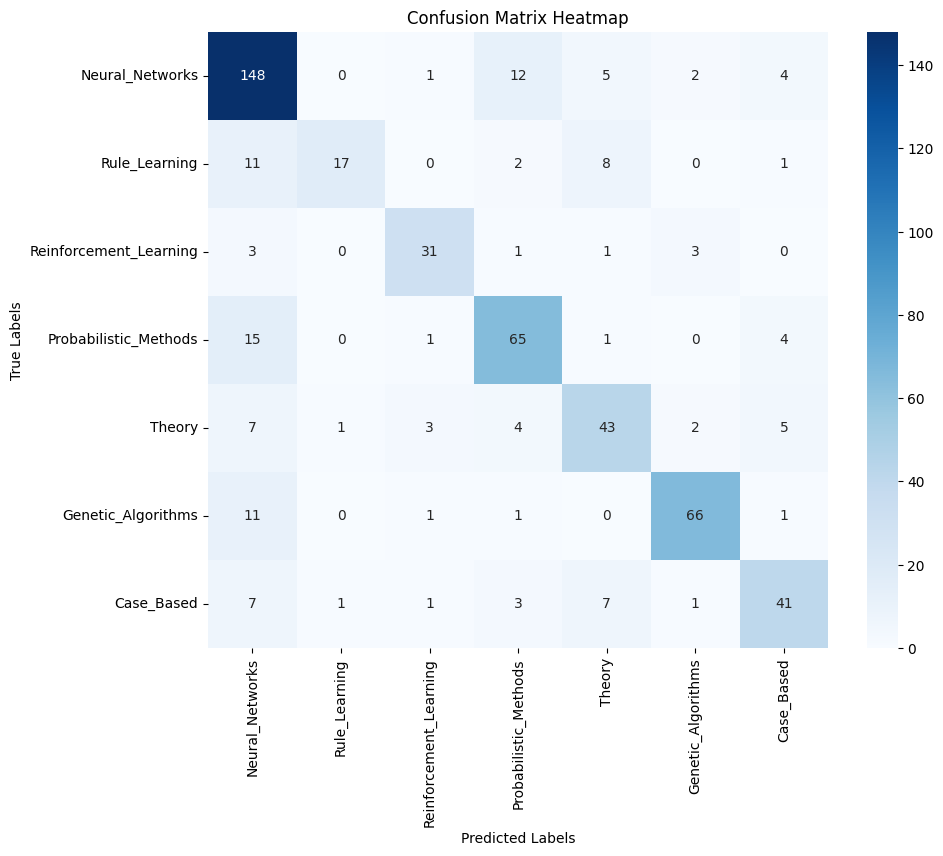

In [25]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(train_features, train_labels)

predicted = model.predict(test_features)
accuracy = accuracy_score(test_labels, predicted)
print(f'Accuracy on test set: {accuracy:.4f}')

cm = confusion_matrix(test_labels, predicted)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### SVM

Accuracy on test set: 0.7214


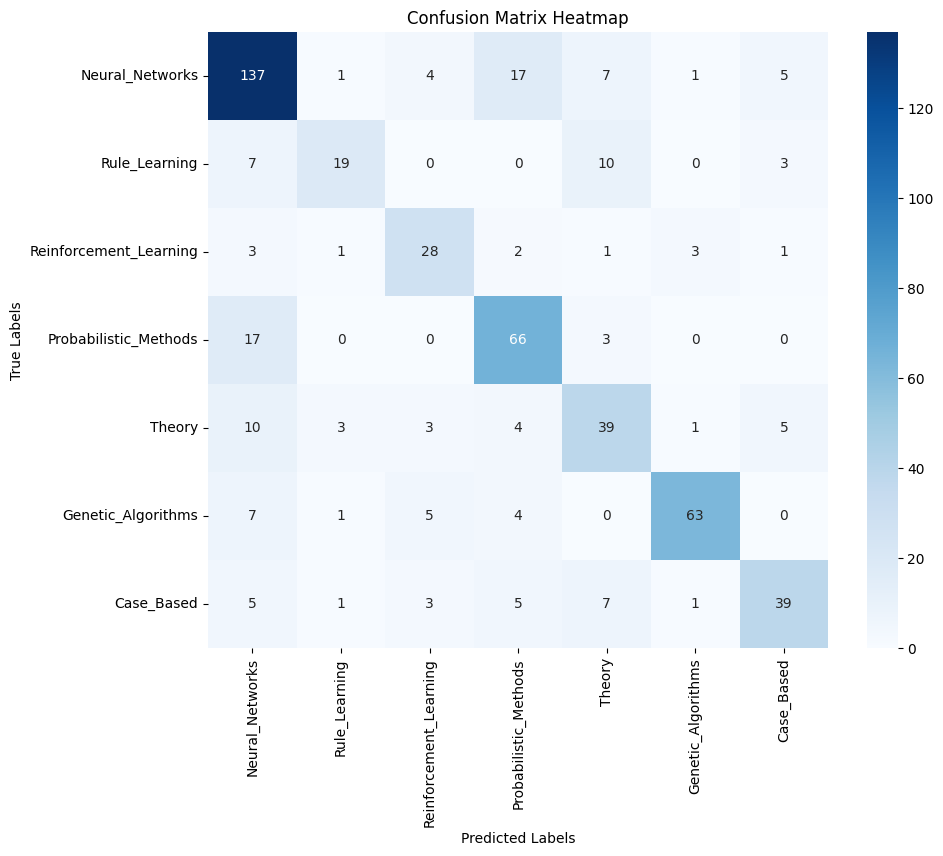

In [27]:
# 训练 SVM 模型
model = SVC(kernel='linear', random_state=42)
model.fit(train_features, train_labels)

# 评估模型
predicted = model.predict(test_features)
accuracy = accuracy_score(test_labels, predicted)
print(f'Accuracy on test set: {accuracy:.4f}')

# 生成混淆矩阵
cm = confusion_matrix(test_labels, predicted)

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

## GCN & GAT model

In [6]:
class GCNNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GCNNet,self).__init__()
        self.GCN1 = GCNConv(num_feature, 16)
        self.GCN2 = GCNConv(16, num_label)  
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GCN1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.GCN2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

class GATNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GATNet,self).__init__()
        self.GAT1 = GATConv(num_feature, 8, heads = 8, concat = True, dropout = 0.6)
        self.GAT2 = GATConv(8*8, num_label, dropout = 0.6)  
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GAT1(x, edge_index)
        x = F.relu(x)
        x = self.GAT2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [7]:
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  # Numpy module.
# random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [8]:
mask = torch.randperm(len(index_dict))
train_mask = mask[:140]
val_mask = mask[140:640]
test_mask = mask[1708:2708]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cora = Data(x = features, edge_index = edge_index.t().contiguous(), y = labels).to(device)

In [9]:
model = GCNNet(features.shape[1], len(label_to_index)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# 用于记录梯度范数的字典
grad_norms = {name: [] for name, param in model.named_parameters() if param.requires_grad}

losses = []
accuracies = []

for epoch in range(200):
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[train_mask], cora.y[train_mask])
    losses.append(loss.item())
    print('epoch: %d loss: %.4f' % (epoch, loss))
    loss.backward()
    
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            grad_norms[name].append(grad_norm)
    
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        _, pred = model(cora).max(dim=1)
        correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
        acc = correct / len(test_mask)
        accuracies.append(acc)
        print('Accuracy: {:.4f}'.format(acc))
        model.train()

final_accuracy = accuracies[-1]
print('Final Classification Accuracy: {:.4f}'.format(final_accuracy))

epoch: 0 loss: 1.9465
epoch: 1 loss: 1.9352
epoch: 2 loss: 1.9226
epoch: 3 loss: 1.9096
epoch: 4 loss: 1.8982
epoch: 5 loss: 1.8828
epoch: 6 loss: 1.8606
epoch: 7 loss: 1.8515
epoch: 8 loss: 1.8409
epoch: 9 loss: 1.8259
Accuracy: 0.2970
epoch: 10 loss: 1.8201
epoch: 11 loss: 1.7931
epoch: 12 loss: 1.7812
epoch: 13 loss: 1.7743
epoch: 14 loss: 1.7296
epoch: 15 loss: 1.7246
epoch: 16 loss: 1.7286
epoch: 17 loss: 1.6980
epoch: 18 loss: 1.6854
epoch: 19 loss: 1.6544
Accuracy: 0.4030
epoch: 20 loss: 1.6416
epoch: 21 loss: 1.6214
epoch: 22 loss: 1.6226
epoch: 23 loss: 1.5981
epoch: 24 loss: 1.5586
epoch: 25 loss: 1.5621
epoch: 26 loss: 1.5405
epoch: 27 loss: 1.5386
epoch: 28 loss: 1.5073
epoch: 29 loss: 1.4964
Accuracy: 0.5240
epoch: 30 loss: 1.4869
epoch: 31 loss: 1.4631
epoch: 32 loss: 1.4486
epoch: 33 loss: 1.4283
epoch: 34 loss: 1.4022
epoch: 35 loss: 1.3966
epoch: 36 loss: 1.3779
epoch: 37 loss: 1.3366
epoch: 38 loss: 1.3363
epoch: 39 loss: 1.3401
Accuracy: 0.5920
epoch: 40 loss: 1.2920

In [12]:
model = GATNet(features.shape[1], len(label_to_index)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# 用于记录梯度范数的字典
grad_norms = {name: [] for name, param in model.named_parameters() if param.requires_grad}

losses = []
accuracies = []

for epoch in range(200):
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[train_mask], cora.y[train_mask])
    losses.append(loss.item())
    print('epoch: %d loss: %.4f' % (epoch, loss))
    loss.backward()
    
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            grad_norms[name].append(grad_norm)
    
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        _, pred = model(cora).max(dim=1)
        correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
        acc = correct / len(test_mask)
        accuracies.append(acc)
        print('Accuracy: {:.4f}'.format(acc))
        model.train()

final_accuracy = accuracies[-1]
print('Final Classification Accuracy: {:.4f}'.format(final_accuracy))

epoch: 0 loss: 1.9657
epoch: 1 loss: 1.9381
epoch: 2 loss: 1.8995
epoch: 3 loss: 1.8809
epoch: 4 loss: 1.8521
epoch: 5 loss: 1.8314
epoch: 6 loss: 1.7865
epoch: 7 loss: 1.8031
epoch: 8 loss: 1.7376
epoch: 9 loss: 1.7251
Accuracy: 0.4360
epoch: 10 loss: 1.7145
epoch: 11 loss: 1.6808
epoch: 12 loss: 1.6532
epoch: 13 loss: 1.6498
epoch: 14 loss: 1.6008
epoch: 15 loss: 1.5963
epoch: 16 loss: 1.5578
epoch: 17 loss: 1.4922
epoch: 18 loss: 1.5215
epoch: 19 loss: 1.4322
Accuracy: 0.5800
epoch: 20 loss: 1.5035
epoch: 21 loss: 1.3664
epoch: 22 loss: 1.3514
epoch: 23 loss: 1.3185
epoch: 24 loss: 1.3687
epoch: 25 loss: 1.3125
epoch: 26 loss: 1.2098
epoch: 27 loss: 1.2848
epoch: 28 loss: 1.1696
epoch: 29 loss: 1.2127
Accuracy: 0.7100
epoch: 30 loss: 1.1616
epoch: 31 loss: 1.1708
epoch: 32 loss: 1.1301
epoch: 33 loss: 1.2044
epoch: 34 loss: 1.1057
epoch: 35 loss: 1.0487
epoch: 36 loss: 1.0601
epoch: 37 loss: 0.9868
epoch: 38 loss: 0.9935
epoch: 39 loss: 1.0291
Accuracy: 0.7890
epoch: 40 loss: 1.0145

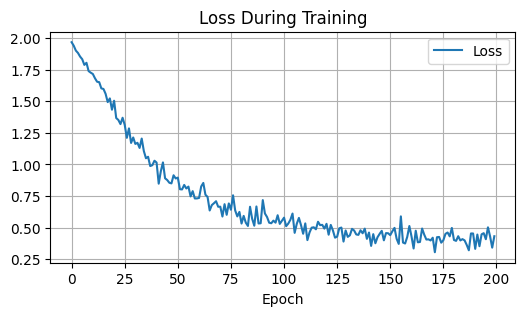

In [13]:
# 可视化loss的变化
plt.figure(figsize=(6,3))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.title('Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

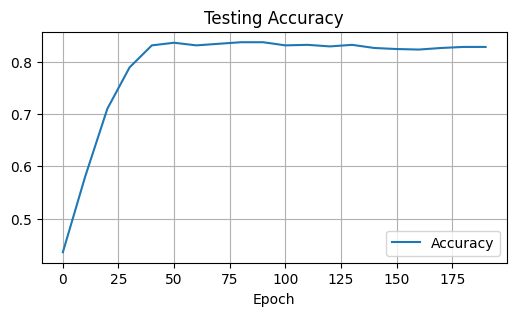

In [14]:
# 可视化accuracy的变化
plt.figure(figsize=(6, 3))
plt.plot(range(0, len(accuracies)*10, 10), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.title('Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

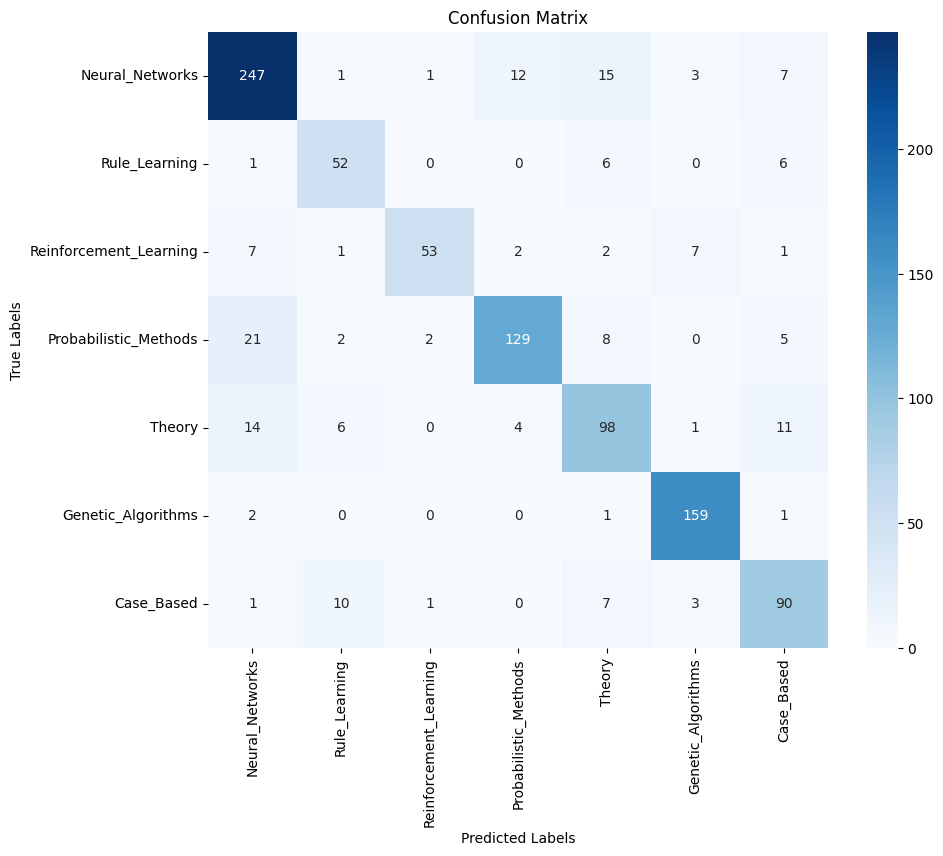

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 计算混淆矩阵
model.eval()
_, pred = model(cora).max(dim=1)
y_true = cora.y[test_mask].cpu().numpy()
y_pred = pred[test_mask].cpu().numpy()
conf_matrix = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵的热力图
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

[[ 3.63708279  2.27461525]
 [ 5.99093298 -0.73798903]
 [ 3.79618352  1.39084818]
 ...
 [ 3.57704034  0.82463799]
 [ 6.17109224 -0.01097419]
 [ 4.85468301  0.769748  ]]


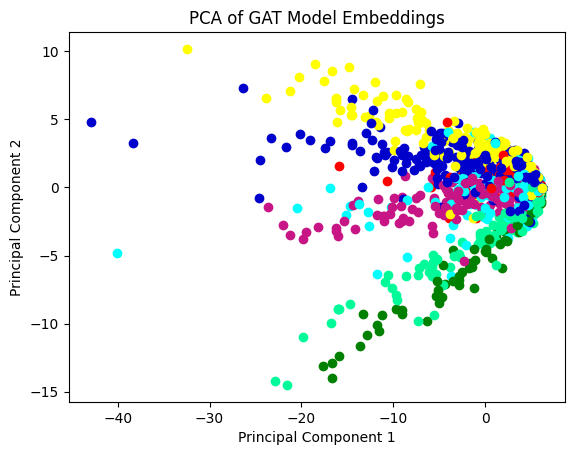

In [13]:
# 提取嵌入
embeddings = []
labels = []

with torch.no_grad():
    out = model(cora)  # 获取模型输出
    for idx in range(len(cora.x)):
        if idx in train_mask or idx in test_mask:  # 只考虑训练和测试数据
            embeddings.append(out[idx].cpu().numpy())
            labels.append(cora.y[idx].item())

# 将嵌入和标签保存到文件中
with open("embeddings.txt", "w") as f:
    for emb in embeddings:
        f.write(" ".join(map(str, emb)) + "\n")

with open("labels.txt", "w") as f:
    for label in labels:
        f.write(str(label) + "\n")

# 从文件中读取嵌入和标签
x, y = [], []
with open("labels.txt", "r") as f:
    data1 = f.read().split("\n")
    for i in data1:
        if i:
            y.append(int(i))

with open("embeddings.txt", "r") as f:
    data1 = f.read().split("\n")
    for item in data1:
        if item:
            a = []
            item1 = item.split(" ")
            for i in item1:
                a.append(float(i))
            x.append(a)

# 应用PCA进行降维
pca = PCA(n_components=2)
reduced_x = pca.fit_transform(x)
print(reduced_x)

# 可视化
color = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
for index, item in enumerate(reduced_x):
    plt.scatter(item[0], item[1], c=color[y[index]])
plt.title('PCA of GAT Model Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

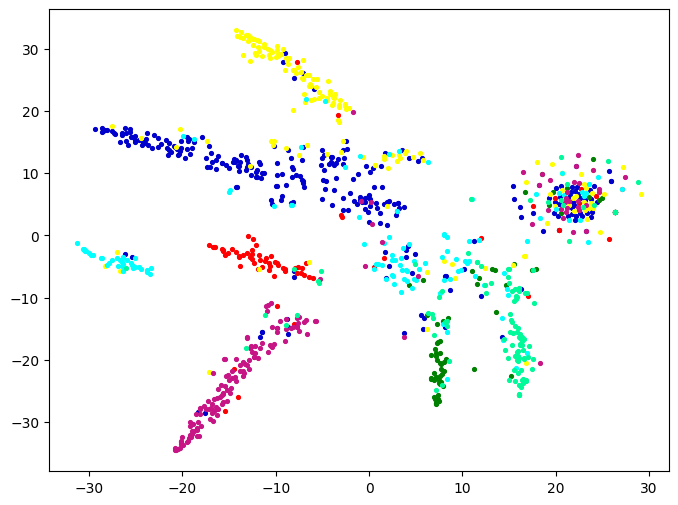

In [27]:
ts = TSNE(n_components=2)
ts.fit_transform(out[test_mask].to('cpu').detach().numpy())

x = ts.embedding_
y = cora.y[test_mask].to('cpu').detach().numpy()

xi = []
for i in range(7):
    xi.append(x[np.where(y==i)])

colors = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
plt.figure(figsize=(8, 6))
for i in range(7):
    plt.scatter(xi[i][:,0],xi[i][:,1],s=30,color=colors[i],marker='.',alpha=1)

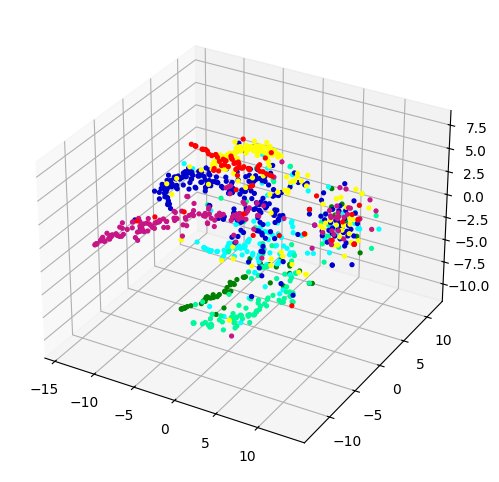

In [29]:
from mpl_toolkits.mplot3d import Axes3D

ts = TSNE(n_components=3)
ts.fit_transform(out[test_mask].to('cpu').detach().numpy())

x = ts.embedding_
y = cora.y[test_mask].to('cpu').detach().numpy()

xi = []
for i in range(7):
    xi.append(x[np.where(y==i)])

colors = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(7):
    ax.scatter(xi[i][:,0], xi[i][:,1], xi[i][:,2], s=30, color=colors[i], marker='.', alpha=1)
plt.show()